In [1]:
import gym
import numpy as np

In [2]:
gym.envs.register(
     id='PendulumDAEEnv-v0',
     entry_point='pendulum.envs:PendulumDAEEnv',
     max_episode_steps=150
)
#env = gym.make('Pendulum-v1')
env = gym.make('PendulumDAEEnv-v0')

In [3]:
env.reset()

array([0.7704137 , 0.63754433, 0.59625006], dtype=float32)

In [4]:
env.step(np.array([0]))

(array([0.743007 , 0.6692836, 1.0852257], dtype=float32),
 -0.5134561692835766,
 False,
 {})

In [5]:
env.step(np.array([0]))

(array([0.6964685, 0.7175874, 1.6043289], dtype=float32),
 -0.655418592876576,
 False,
 {})

In [ ]:
import gym
import jax
import coax
import haiku as hk
import jax.numpy as jnp
from numpy import prod
import optax


# the name of this script
name = 'ddpg'

# the Pendulum MDP
env = coax.wrappers.TrainMonitor(env, name=name, tensorboard_dir=f"./data/tensorboard/{name}")


def func_pi(S, is_training):
    seq = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(prod(env.action_space.shape), w_init=jnp.zeros),
        hk.Reshape(env.action_space.shape),
    ))
    mu = seq(S)
    return {'mu': mu, 'logvar': jnp.full_like(mu, -10)}  # (almost) deterministic


def func_q(S, A, is_training):
    seq = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(1, w_init=jnp.zeros), jnp.ravel
    ))
    X = jnp.concatenate((S, A), axis=-1)
    return seq(X)


# main function approximators
pi = coax.Policy(func_pi, env)
q = coax.Q(func_q, env, action_preprocessor=pi.proba_dist.preprocess_variate)


# target network
q_targ = q.copy()
pi_targ = pi.copy()


# experience tracer
tracer = coax.reward_tracing.NStep(n=5, gamma=0.9)
buffer = coax.experience_replay.SimpleReplayBuffer(capacity=25000)


# updaters
qlearning = coax.td_learning.QLearning(
    q, pi_targ, q_targ, loss_function=coax.value_losses.mse, optimizer=optax.adam(1e-3))
determ_pg = coax.policy_objectives.DeterministicPG(pi, q_targ, optimizer=optax.adam(1e-4))


# action noise
noise = coax.utils.OrnsteinUhlenbeckNoise(mu=0., sigma=0.2, theta=0.15)


# train
while env.T < 1000000:
    s = env.reset()
    noise.reset()
    noise.sigma *= 0.99  # slowly decrease noise scale

    for t in range(env.spec.max_episode_steps):
        a = noise(pi(s))
        s_next, r, done, info = env.step(a)

        # trace rewards and add transition to replay buffer
        tracer.add(s, a, r, done)
        while tracer:
            buffer.add(tracer.pop())

        # learn
        if len(buffer) >= 5000:
            transition_batch = buffer.sample(batch_size=128)

            metrics = {'OrnsteinUhlenbeckNoise/sigma': noise.sigma}
            metrics.update(determ_pg.update(transition_batch))
            metrics.update(qlearning.update(transition_batch))
            env.record_metrics(metrics)

            # sync target networks
            q_targ.soft_update(q, tau=0.001)
            pi_targ.soft_update(pi, tau=0.001)

        if done:
            break

        s = s_next


/opt/conda/lib/python3.9/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
[ddpg|absl|INFO] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[ddpg|absl|INFO] Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
[ddpg|absl|INFO] Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[ddpg|absl|WARNING] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/opt/conda/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
[d

In [ ]:
env.close()

In [ ]:
s = env.reset()
s_list = []
a_list = []
for t in range(env.spec.max_episode_steps):
    a = pi(s)
    s_next, r, done, info = env.step(a)
    s_list += [s_next]
    s = s_next
   # print(s_next)
    
    a_list += [a]
env.close()


In [ ]:

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2)
axes[0].plot([item[0] for item in  a_list])
axes[1].plot([item[2] for item in  s_list])

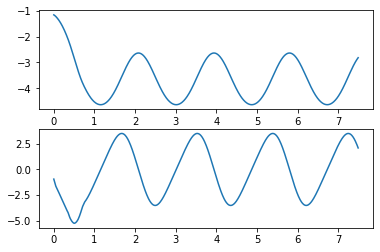

In [30]:
fig, axes = plt.subplots(nrows=2)
axes[0].plot(env.dae.Time,env.dae.get_values('theta'))
axes[1].plot(env.dae.Time,env.dae.get_values('omega'))


In [12]:
env.close()

In [ ]:
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]
[ 0.66894764 -0.7433095  -0.13705207]